<font size="8">Introduction</font>

<font size="3">This is the 1st part of the IBM Data Science capstone project. In this project, I will implement all my learned knowledge in this final project, which includes 9 different courses and requires more than 4 month learning time. The first part of the final project requires us to explore, segment, and cluster the neighborhoods in the city of Toronto based on the venues from the social media, foursquare website. And the main organization of this project can be summarized as follows:1) crawl the Borough and the Neighborhood data from the wiki website. 2) use geopy package to obtain geo location data and add these data to our neighborhood data. 3) explore the foursquare website to analyze each neighborhood 4) based on the top 10 venues in each neighborhoods and their categories, we use cluster method including k-means, dbscan, and hierarchical clustering method</font>

<font size="3">These 9 different courses in this IBM program are listed as:
1.What is Data Science?
2.Tools for Data Science
3.Data Science Methodology
4.Python for Data Science and AI
5.Databases and SQL for Data Science
6.Data Analysis with Python
7.Data Visualization with Python
8.Machine Learning with Python
9.Applied Data Science Capstone</font>

In [2]:
import numpy as np 
import pandas as pd 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json 
!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim 
import requests 
from pandas.io.json import json_normalize 

import matplotlib.cm as cm
import matplotlib.colors as colors

!conda install -c conda-forge folium=0.5.0 --yes 
import folium 
!conda config --add channels conda-forge 
!conda install beautifulsoup4 bs4 --yes
from bs4 import BeautifulSoup
!conda install -c conda-forge lxml --yes
import lxml
print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-1.22.0               |     pyh9f0ad1d_0          63 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          97 KB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.50-py_0
  geopy              conda-forge/noarch::geopy-1.22.0-pyh9f0ad1d_0



geopy-1.22.0         | 63 KB     | ##################################### | 100% 
geographiclib-1.50   | 34 KB     | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: 

<font size="3">For the Toronto neighborhood data, a Wikipedia page: https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M exists that has all the information we need to explore and cluster the neighborhoods in Toronto. We will have to crawl the Wikipedia page, clean it, and then read it into a pandas dataframe so that it is in a structured format.</font>

In [10]:
# download data
r = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M')
soup = BeautifulSoup(r.text, 'html.parser')
table=soup.find('table', attrs={'class':'wikitable sortable'})
headers=table.findAll('th')
for i, head in enumerate(headers): headers[i]=str(headers[i]).replace("<th>","").replace("</th>","").replace("\n","")
    
rows=table.findAll('tr')
rows=rows[1:len(rows)]
for i, row in enumerate(rows): rows[i] = str(rows[i]).replace("\n</td></tr>","").replace("<tr>\n<td>","").replace("\n</td>\n<td>","|")
    
df=pd.DataFrame(rows)
df[headers] = df[0].str.split("|", n = 2, expand = True) 
df.drop(columns=[0],inplace=True)

# clean data
df.drop(df[(df.Borough == "Not assigned")].index, inplace=True)
df.Neighborhood.replace("Not assigned", df.Borough, inplace=True)
df = df.drop_duplicates()
df = df.reset_index(drop=True) 

df.update(df.Neighborhood.loc[lambda x: x.str.contains('Toronto')].str.replace(" Toronto",""))
df.update(df.Borough.loc[lambda x: x.str.contains('Toronto')].str.replace(" Toronto",""))

# splite multiple neighborhoods in the same rows into multiple rows
df_wo_postal = df.iloc[:,1:]
df_wop_nei = df_wo_postal['Neighborhood'].str.split(',', expand=True)
df_wop_nei = df_wop_nei.stack()
df_wop_nei = df_wop_nei.reset_index(level=1, drop=True)
df_wop_nei = df_wop_nei.to_frame()
df_new = df_wo_postal.drop(['Neighborhood'], axis=1).join(df_wop_nei)
df_new.rename(columns={0:"Neighborhood"},inplace=True)



In [87]:
def add_geo_location(df):
    df["Latitude"] = 0
    df["Longitude"] = 0
    length = df.shape[0]
    for i in range(length):
        address = df.iloc[i,1]+',Toronto, CA'
        geolocator = Nominatim(user_agent="ny_explorer")
        la,lo = calculate_geo_location(address, geolocator )
        df.iloc[i,-2] = la
        df.iloc[i,-1] = lo

In [88]:
def calculate_geo_location(address, geolocator):
    location = geolocator.geocode(address)
    try:
        latitude = location.latitude
        longitude = location.longitude
    except:
        latitude = -10000
        longitude = -10000
    return latitude, longitude
    

In [89]:
# add Geo-spatial data
add_geo_location(df_new)
df_new.drop(df_new[df_new["Latitude"]==-10000].index,inplace=True)


<font size="3">Now let's check the shape of our data and its contents.</font>

In [90]:
df_new.head(20)

,Borough,Neighborhood,Latitude,Longitude
0,North York,Parkwoods,43.758800,-79.320197
1,North York,Victoria Village,43.732658,-79.311189
2,Downtown,Regent Park,43.660706,-79.360457
2,Downtown,Harbourfront,43.640080,-79.380150
3,North York,Lawrence Manor,43.722079,-79.437507
3,North York,Lawrence Heights,43.722778,-79.450933
5,Etobicoke,Islington Avenue,43.679484,-79.538909
5,Etobicoke,Humber Valley Village,43.666472,-79.524314
6,Scarborough,Malvern,43.809196,-79.221701
6,Scarborough,Rouge,43.804930,-79.165837


In [91]:
df_new.shape

(161, 4)

In [92]:
df_new["Borough"].unique()

array(['North York', 'Downtown', 'Etobicoke', 'Scarborough', 'East York',
       'East', 'West', 'Central', 'York'], dtype=object)

In [18]:
neighborhoods = df_new

<font size="3">Let's get the geo locations of the Toronto city and drwa the geo map of this city with neighborhoods popping up.</font>

In [93]:
address = 'Toronto, CA'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto City are 43.6534817, -79.3839347.


In [94]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#cc5831',
        fill_opacity=0.5,
        parse_html=True).add_to(map_toronto)  
    
map_toronto

<font size="3">Define Foursquare Credentials and Version.</font>

In [106]:
CLIENT_ID = 'DBZSGY1Q5IHCU3JFTVYQET0CVDCC3JRJKSJWIPOBWELVRS1V' # your Foursquare ID
CLIENT_SECRET = 'RIOFG2FBIYWDJS0ML4DLS0NFTIAKFJ1AHGLQGHCST2HLHKK5' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 100
radius = 500
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: DBZSGY1Q5IHCU3JFTVYQET0CVDCC3JRJKSJWIPOBWELVRS1V
CLIENT_SECRET:RIOFG2FBIYWDJS0ML4DLS0NFTIAKFJ1AHGLQGHCST2HLHKK5


<font size="3">Explore Neighborhoods in Toronto.</font>

In [107]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [111]:
toronto_venues = getNearbyVenues(names=neighborhoods['Neighborhood'],
                                   latitudes=neighborhoods['Latitude'],
                                   longitudes=neighborhoods['Longitude']
                                  )

Parkwoods
Victoria Village
Regent Park
 Harbourfront
Lawrence Manor
 Lawrence Heights
Islington Avenue
 Humber Valley Village
Malvern
 Rouge
Don Mills
Garden District
 Ryerson
Glencairn
West Deane Park
 Princess Gardens
 Martin Grove
 Islington
 Cloverdale
Rouge Hill
 Port Union
 Highland Creek
Don Mills
Woodbine Heights
St. James Town
Eringate
 Bloordale Gardens
 Old Burnhamthorpe
 Markland Wood
Guildwood
 Morningside
 West Hill
The Beaches
Berczy Park
Woburn
Leaside
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor
 Wilson Heights
 Downsview North
Thorncliffe Park
Richmond
 Adelaide
 King
Dufferin
 Dovercourt Village
Scarborough Village
Fairview
 Henry Farm
 Oriole
Northwood Park
 York University
Harbourfront East
 Union Station
 Islands
Little Portugal
 Trinity
Kennedy Park
 Ionview
 East Birchmount Park
Bayview Village
Downsview
The Danforth West
 Riverdale
Toronto Dominion Centre
 Design Exchange
Brockton
 Parkdale Village
 Exhibition Place
Golden Mile
 Clairlea
 Oakridge
York M

In [112]:
toronto_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.7588,-79.320197,Allwyn's Bakery,43.759840,-79.324719,Caribbean Restaurant
1,Parkwoods,43.7588,-79.320197,LCBO,43.757774,-79.314257,Liquor Store
2,Parkwoods,43.7588,-79.320197,Petro-Canada,43.757950,-79.315187,Gas Station
3,Parkwoods,43.7588,-79.320197,Shoppers Drug Mart,43.760857,-79.324961,Pharmacy
4,Parkwoods,43.7588,-79.320197,Pizza Pizza,43.760231,-79.325666,Pizza Place


<font size="3">Let's check how many venues were returned for each neighborhood.</font>

In [113]:
pd.DataFrame(toronto_venues.groupby('Neighborhood').count()["Venue"]).sort_values(by="Venue")

,Venue
Neighborhood,
Kingsview Village,1
Eringate,1
Steeles East,1
Steeles West,1
Richmond,2
Port Union,2
Rouge Hill,2
Richview Gardens,2
Rouge,2


<font size="3">Analyze Each Neighborhood.</font>


In [114]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")
toronto_venues.drop(toronto_venues[toronto_venues['Venue Category']=="Neighborhood"].index,inplace=True)

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Yoga Studio,Accessories Store,Afghan Restaurant,African Restaurant,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Workshop,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Big Box Store,Bike Shop,Bike Trail,Bistro,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cable Car,Café,Camera Store,Cantonese Restaurant,Caribbean Restaurant,Castle,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Rec Center,College Stadium,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Costume Shop,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dive Bar,Doctor's Office,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Service,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hakka Restaurant,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hong Kong Restaurant,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Housing Development,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Laser Tag,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Leather Goods Store,Library,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Luggage Store,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Moving Target,Museum,Music School,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Night Market,Nightclub,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Supply Store,Paintball Field,Pakistani Restaurant,Paper / Office Supplies Store,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Photography Lab,Piano Bar,Pie Shop,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Poutine Place,Print Shop,Pub,Racetrack,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Restaurant,River,Rock Climbing Spot,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Repair,Shoe Store,Shopping Mall,Shopping Plaza,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soccer Stadium,Social Club,Soup Place,South Ame

<font size="3">Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category.</font>

In [115]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped.head(2)

,Neighborhood,Yoga Studio,Accessories Store,Afghan Restaurant,African Restaurant,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Workshop,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Big Box Store,Bike Shop,Bike Trail,Bistro,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cable Car,Café,Camera Store,Cantonese Restaurant,Caribbean Restaurant,Castle,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Rec Center,College Stadium,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Costume Shop,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dive Bar,Doctor's Office,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Service,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hakka Restaurant,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hong Kong Restaurant,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Housing Development,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Laser Tag,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Leather Goods Store,Library,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Luggage Store,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Moving Target,Museum,Music School,Music Store,Music Venue,Nail Salon,New American Restaurant,Night Market,Nightclub,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Supply Store,Paintball Field,Pakistani Restaurant,Paper / Office Supplies Store,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Photography Lab,Piano Bar,Pie Shop,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Poutine Place,Print Shop,Pub,Racetrack,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Restaurant,River,Rock Climbing Spot,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Repair,Shoe Store,Shopping Mall,Shopping Plaza,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soccer Stadium,Social Club,Soup Place,South Ame

In [116]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [117]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Lawrence Park,Sushi Restaurant,Italian Restaurant,Coffee Shop,Bakery,Bank,Pub,Pizza Place,Asian Restaurant,Cosmetics Shop,Diner
1,Adelaide,Coffee Shop,Café,Gastropub,American Restaurant,Restaurant,Japanese Restaurant,Gym,Cosmetics Shop,Seafood Restaurant,Salad Place
2,Agincourt North,Bank,Bakery,Chinese Restaurant,Movie Theater,Discount Store,Sporting Goods Shop,Fast Food Restaurant,Liquor Store,Juice Bar,Coffee Shop
3,Bloordale Gardens,Convenience Store,Bank,Intersection,Donut Shop,Coffee Shop,Shipping Store,Sandwich Place,Food Court,Food & Drink Shop,Flower Shop
4,Cabbagetown,Restaurant,Café,Coffee Shop,Pizza Place,Indian Restaurant,Bakery,Japanese Restaurant,Italian Restaurant,Beer Store,Gastropub


In [118]:
# let's save our dataframe first
neighborhoods_venues_sorted.to_csv('neighborhoods_venues_sorted.csv') 
neighborhoods.to_csv('neighborhoods.csv') 
toronto_grouped.to_csv('toronto_grouped.csv') 

<font size="3">Cluster Neighbors. Let's first try k-means. We plot the elbow figure to find the best k </font>

([<matplotlib.axis.XTick at 0x7fb1d9458780>,
 <a list of 18 Text xticklabel objects>)

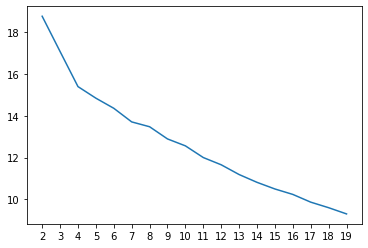

In [119]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt 
errors=np.zeros(18) # use this array to save distortions errors
toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)
shape_l, shape_w = toronto_grouped_clustering.shape
for i in range(2,20):
        kmeans=KMeans(n_clusters=i,random_state=0).fit(toronto_grouped_clustering)
        m=kmeans.labels_
        c=kmeans.cluster_centers_
        for j in range(shape_l):
            c1 = c[m[j]]
            x = toronto_grouped_clustering.values[j]
            errors[i-2]=errors[i-2]+sum((x-c1)**2)
plt.plot(np.arange(2,20),errors )
plt.xticks(np.arange(2,20))
    


<font size="3">Based on the figure, k=4 is the inflexion point. </font>

In [120]:
kclusters = 4
toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)


In [121]:
pd.DataFrame(kmeans.labels_).head()

,0
0,0
1,0
2,0
3,0
4,0


In [43]:
neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Lawrence Park,Italian Restaurant,Sushi Restaurant,Coffee Shop,Bakery,Bank,Pub,Pizza Place,Cosmetics Shop,Asian Restaurant,Tea Room
1,Adelaide,Coffee Shop,Café,Bar,Chinese Restaurant,Asian Restaurant,Pub,Italian Restaurant,Breakfast Spot,Sushi Restaurant,Hotel
2,Agincourt North,Bank,Chinese Restaurant,Bakery,Fast Food Restaurant,Beer Store,Liquor Store,Frozen Yogurt Shop,Sporting Goods Shop,Pizza Place,Movie Theater
3,Albion Gardens,Café,Soccer Stadium,Bar,Bakery,Supermarket,Grocery Store,Park,Outlet Store,Furniture / Home Store,Shopping Plaza
4,Bathurst Quay,Coffee Shop,Café,Park,Garden,Tunnel,Sushi Restaurant,Grocery Store,Gym,Bank,Harbor / Marina


<font size="3">Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood. </font>

In [122]:
neighborhoods_venues_sorted_tempt = neighborhoods_venues_sorted# maintain neighborhoods_venues_sorted for different methods
neighborhoods_venues_sorted_tempt['Cluster Labels']= pd.DataFrame(kmeans.labels_)[0]
toronto_merged = neighborhoods_venues_sorted_tempt
toronto_merged = pd.merge(toronto_merged, neighborhoods, how='left', on='Neighborhood')
toronto_merged.head() 

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels,Borough,Latitude,Longitude
0,Lawrence Park,Sushi Restaurant,Italian Restaurant,Coffee Shop,Bakery,Bank,Pub,Pizza Place,Asian Restaurant,Cosmetics Shop,Diner,0,Central,43.729199,-79.403252
1,Adelaide,Coffee Shop,Café,Gastropub,American Restaurant,Restaurant,Japanese Restaurant,Gym,Cosmetics Shop,Seafood Restaurant,Salad Place,0,Downtown,43.650486,-79.379498
2,Agincourt North,Bank,Bakery,Chinese Restaurant,Movie Theater,Discount Store,Sporting Goods Shop,Fast Food Restaurant,Liquor Store,Juice Bar,Coffee Shop,0,Scarborough,43.808038,-79.266439
3,Bloordale Gardens,Convenience Store,Bank,Intersection,Donut Shop,Coffee Shop,Shipping Store,Sandwich Place,Food Court,Food & Drink Shop,Flower Shop,0,Etobicoke,43.635317,-79.563674
4,Cabbagetown,Restaurant,Café,Coffee Shop,Pizza Place,Indian Restaurant,Bakery,Japanese Restaurant,Italian Restaurant,Beer Store,Gastropub,0,Downtown,43.664473,-79.366986


In [123]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    #cluster = int(cluster)
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

<font size="3">Based on the above figure, we find that clusters may have arbitrary-shape of clusters. This is reasonable, since venues are distributed sparsely in the Toronto city, which can make distributions to different neighborhoods in different weights. Besides, some neighborhoods have only one adjacent venue, which can be viewed as outliers. Thus, in the following section, let's try DBSCAN method. Also, DBSCAN have advantages in dealing with outliers, geo data and arbitrary-shape data(including cluster-in-cluster data)</font>

In [124]:
from sklearn.cluster import DBSCAN 

<font size="3">Let's find the best area radium(epsilon). Here, I use a my proposed heuristic method. We can set a certain point in the feature space, like array(0,0,0,0,0...0). Then we calculate the mean distance between each point in each cluster and the selected point. Then we use the mean distance of all clusters as the criteria for choosing the best parameter. </font>

([<matplotlib.axis.XTick at 0x7fb1d3d18518>,
 <a list of 18 Text xticklabel objects>)

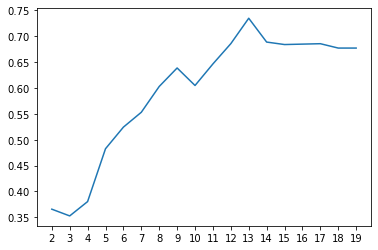

In [125]:
errors=np.zeros(18) # use this array to save distortions errors
epsilon = 0.04
minimumSamples = 2
shape_l, shape_w = toronto_grouped_clustering.shape
for i in range(2,20):
        db=DBSCAN(eps=epsilon*i, min_samples=minimumSamples).fit(toronto_grouped_clustering)
        m=db.labels_
        c=np.zeros(shape_w)
        np_length = len(np.unique(db.labels_))

        mean_dis_cluster = [[] for _ in range(np_length)]
        for j in range(shape_l):
            x = toronto_grouped_clustering.values[j]
            classier = m[j]
        
            mean_dis_cluster[classier].append(sum(x**2)**0.5) 
        for k in range(np_length):
            mean_dis_cluster[k] = np.mean(mean_dis_cluster[k])
                
        errors[i-2]=np.mean(mean_dis_cluster)
plt.plot(np.arange(2,20),errors )
plt.xticks(np.arange(2,20))

<font size="3">Based on the above figure, the epsilon should be 0.28. </font>

In [126]:

epsilon = 0.28
minimumSamples = 2
db = DBSCAN(eps=epsilon, min_samples=minimumSamples).fit(toronto_grouped_clustering)
labels = db.labels_
np.unique(labels)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8])

In [127]:
labels += 1

In [128]:
neighborhoods_venues_sorted_tempt = neighborhoods_venues_sorted# maintain neighborhoods_venues_sorted for different methods
neighborhoods_venues_sorted_tempt['Cluster Labels']= pd.DataFrame(labels)[0]
toronto_merged = neighborhoods_venues_sorted_tempt
toronto_merged = pd.merge(toronto_merged, neighborhoods, how='left', on='Neighborhood')
toronto_merged.head() 

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels,Borough,Latitude,Longitude
0,Lawrence Park,Sushi Restaurant,Italian Restaurant,Coffee Shop,Bakery,Bank,Pub,Pizza Place,Asian Restaurant,Cosmetics Shop,Diner,1,Central,43.729199,-79.403252
1,Adelaide,Coffee Shop,Café,Gastropub,American Restaurant,Restaurant,Japanese Restaurant,Gym,Cosmetics Shop,Seafood Restaurant,Salad Place,1,Downtown,43.650486,-79.379498
2,Agincourt North,Bank,Bakery,Chinese Restaurant,Movie Theater,Discount Store,Sporting Goods Shop,Fast Food Restaurant,Liquor Store,Juice Bar,Coffee Shop,1,Scarborough,43.808038,-79.266439
3,Bloordale Gardens,Convenience Store,Bank,Intersection,Donut Shop,Coffee Shop,Shipping Store,Sandwich Place,Food Court,Food & Drink Shop,Flower Shop,0,Etobicoke,43.635317,-79.563674
4,Cabbagetown,Restaurant,Café,Coffee Shop,Pizza Place,Indian Restaurant,Bakery,Japanese Restaurant,Italian Restaurant,Beer Store,Gastropub,1,Downtown,43.664473,-79.366986


In [129]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)
kclusters = 9
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    #cluster = int(cluster)
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

<font size="3">Let's use the hierarchical clustering method to re-cluster the neighborhoods. </font>

In [144]:
from sklearn.cluster import AgglomerativeClustering 
feature_mtx = toronto_grouped_clustering.values 
agglom = AgglomerativeClustering(n_clusters = 5, linkage = 'complete')
agglom.fit(feature_mtx)
agglom.labels_

array([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 4, 4, 1, 4, 4, 1, 1,
       1, 1, 4, 4, 4, 4, 4, 4, 1, 4, 1, 1, 4, 4, 4, 4, 4, 4, 4, 0, 1, 4,
       4, 2, 4, 4, 4, 4, 4, 1, 4, 4, 4, 1, 4, 4, 3, 4, 4, 1, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 4, 4, 1, 4, 0, 4, 4, 4, 4, 4, 4,
       0, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 0, 4, 4, 4, 1, 4, 4,
       4, 1, 4, 2, 1, 4, 4, 4, 4, 4, 1, 4, 4, 2, 4, 4, 4, 2, 1, 4, 0, 4,
       4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 1, 1, 0, 4, 4, 4, 4, 1, 4, 4])

In [137]:
neighborhoods_venues_sorted_tempt = neighborhoods_venues_sorted# maintain neighborhoods_venues_sorted for different methods
neighborhoods_venues_sorted_tempt['Cluster Labels']= pd.DataFrame(agglom.labels_)[0]
toronto_merged = neighborhoods_venues_sorted_tempt
toronto_merged = pd.merge(toronto_merged, neighborhoods, how='left', on='Neighborhood')
toronto_merged.head() 

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels,Borough,Latitude,Longitude
0,Lawrence Park,Sushi Restaurant,Italian Restaurant,Coffee Shop,Bakery,Bank,Pub,Pizza Place,Asian Restaurant,Cosmetics Shop,Diner,1,Central,43.729199,-79.403252
1,Adelaide,Coffee Shop,Café,Gastropub,American Restaurant,Restaurant,Japanese Restaurant,Gym,Cosmetics Shop,Seafood Restaurant,Salad Place,1,Downtown,43.650486,-79.379498
2,Agincourt North,Bank,Bakery,Chinese Restaurant,Movie Theater,Discount Store,Sporting Goods Shop,Fast Food Restaurant,Liquor Store,Juice Bar,Coffee Shop,1,Scarborough,43.808038,-79.266439
3,Bloordale Gardens,Convenience Store,Bank,Intersection,Donut Shop,Coffee Shop,Shipping Store,Sandwich Place,Food Court,Food & Drink Shop,Flower Shop,1,Etobicoke,43.635317,-79.563674
4,Cabbagetown,Restaurant,Café,Coffee Shop,Pizza Place,Indian Restaurant,Bakery,Japanese Restaurant,Italian Restaurant,Beer Store,Gastropub,1,Downtown,43.664473,-79.366986


In [138]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)
kclusters = 9
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    #cluster = int(cluster)
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters